#  PRÉDICTION ÉMISSIONS GES - BÂTIMENTS SEATTLE
## Notebook 04 : Modélisation Complète avec Pipelines

---

###  Informations

**Dataset** : 1,666 bâtiments (2015-2016)  
**Objectif** : Comparer 2 approches prédictives  
**Date** : Janvier 2026

###  Les 2 Modèles

1. **Modèle 1** : Variables disponibles au permis (sans ENERGY STAR)
2. **Modèle 2** : Avec ENERGY STAR Score

---

# Section 0 : Configuration et Imports

In [ ]:
# ============================================================================
# IMPORTS STANDARDS
# ============================================================================

import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import sys
import importlib.util

# ============================================================================
# CONFIGURATION CHEMINS - VERSION CORRIGÉE
# ============================================================================

# Chemin absolu du projet
PROJECT_ROOT = Path(r"c:\Users\LENOVO\CO2-Emission-in-Seattle-REGO3")

# Vérifier que le projet existe
if not PROJECT_ROOT.exists():
    raise FileNotFoundError(f"❌ Le projet n'existe pas à : {PROJECT_ROOT}")

SRC_PATH = PROJECT_ROOT / 'src'

if not SRC_PATH.exists():
    raise FileNotFoundError(f"❌ Le dossier src n'existe pas à : {SRC_PATH}")

if str(SRC_PATH) not in sys.path:
    sys.path.insert(0, str(SRC_PATH))
if str(PROJECT_ROOT) not in sys.path:
    sys.path.insert(0, str(PROJECT_ROOT))

print(f"✓ PROJECT_ROOT : {PROJECT_ROOT}")
print(f"✓ SRC_PATH : {SRC_PATH}")
print(f"✓ Chemins configurés")

✓ PROJECT_ROOT : c:\Users\LENOVO\CO2-Emission-in-Seattle-REGO3
✓ SRC_PATH : c:\Users\LENOVO\CO2-Emission-in-Seattle-REGO3\src
✓ Chemins configurés


In [ ]:
# ============================================================================
# IMPORTS MODULES PERSONNALISÉS
# ============================================================================

# modeling_utils
spec_modeling = importlib.util.spec_from_file_location("modeling_utils", SRC_PATH / "modeling_utils.py")
modeling_utils = importlib.util.module_from_spec(spec_modeling)
spec_modeling.loader.exec_module(modeling_utils)

# evaluation_utils
spec_eval = importlib.util.spec_from_file_location("evaluation_utils", SRC_PATH / "evaluation_utils.py")
evaluation_utils = importlib.util.module_from_spec(spec_eval)
spec_eval.loader.exec_module(evaluation_utils)

# visualization_utils
spec_viz = importlib.util.spec_from_file_location("visualization_utils", SRC_PATH / "visualization_utils.py")
visualization_utils = importlib.util.module_from_spec(spec_viz)
spec_viz.loader.exec_module(visualization_utils)

# Extraire fonctions
train_multiple_models = modeling_utils.train_multiple_models
save_model = modeling_utils.save_model
get_feature_importance = modeling_utils.get_feature_importance
compare_models = modeling_utils.compare_models

evaluate_model = evaluation_utils.evaluate_model
cv_evaluate_model = evaluation_utils.cv_evaluate_model
compute_residuals_stats = evaluation_utils.compute_residuals_stats
calculate_metrics_summary = evaluation_utils.calculate_metrics_summary
compare_model_performance = evaluation_utils.compare_model_performance

plot_predictions = visualization_utils.plot_predictions
plot_residuals_distribution = visualization_utils.plot_residuals_distribution
plot_feature_importance = visualization_utils.plot_feature_importance
plot_model_comparison = visualization_utils.plot_model_comparison
plot_comparison_two_models = visualization_utils.plot_comparison_two_models

print("✓ Modules personnalisés importés")

✓ Modules personnalisés importés


In [ ]:
# ============================================================================
# SCIKIT-LEARN
# ============================================================================

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR


print("\n" + "="*80)
print("IMPORTS TERMINÉS")
print("="*80)


IMPORTS TERMINÉS


In [ ]:
# ============================================================================
# CONFIGURATION
# ============================================================================

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

pd.set_option('display.max_columns', None)
pd.set_option('display.precision', 4)

plt.style.use('seaborn-v0_8-darkgrid')
plt.rcParams['figure.figsize'] = (12, 6)
sns.set_palette("husl")

# Chemins
DATA_DIR = PROJECT_ROOT / 'data'
INTERIM_DIR = DATA_DIR / 'interim_data'
MODELS_DIR = PROJECT_ROOT / 'models'
RESULTS_DIR = PROJECT_ROOT / 'results'
FIGURES_DIR = RESULTS_DIR / 'figures'

for directory in [MODELS_DIR, RESULTS_DIR, FIGURES_DIR]:
    directory.mkdir(parents=True, exist_ok=True)

print("✓ Configuration terminée")

✓ Configuration terminée


# Section 1 : Chargement des Données

In [ ]:
print("="*80)
print("CHARGEMENT DES DONNÉES")
print("="*80)

train_df = pd.read_csv(INTERIM_DIR / 'train_with_features.csv')
test_df = pd.read_csv(INTERIM_DIR / 'test_with_features.csv')

print(f"\n✓ Train : {train_df.shape}")
print(f"✓ Test  : {test_df.shape}")

display(train_df.head())

CHARGEMENT DES DONNÉES

✓ Train : (1332, 31)
✓ Test  : (334, 31)


,OSEBuildingID,BuildingType,PrimaryPropertyType,Address,Neighborhood,Latitude,Longitude,ListOfAllPropertyUseTypes,LargestPropertyUseType,LargestPropertyUseTypeGFA,SecondLargestPropertyUseType,SecondLargestPropertyUseTypeGFA,ENERGYSTARScore,SteamUse(kBtu),Electricity(kWh),NaturalGas(therms),TotalGHGEmissions,TotalGHGEmissions_log,GFA_per_floor,Parking_ratio,Building_age_squared,Is_old_building,Size_floors,Age_size,Age_floors,GFA_sqrt,Floors_squared,Neighborhood_mean,Neighborhood_std,PrimaryPropertyType_mean,PrimaryPropertyType_std
0,23701.0,NonResidential,Warehouse,1136 S. Albro Place,GREATER DUWAMISH,47.5465,-122.3170,"Non-Refrigerated Warehouse, Office",Non-Refrigerated Warehouse,28000.0,Office,4000.0,73.0,0.0000,5.7582e+05,0.0000,13.700,2.6878,31899.9681,0.0,2809,1,31900.0,1.6907e+06,53.0,178.6057,1.0000,3.5022,1.2672,3.1054,1.1998
1,401.0,NonResidential,Hotel,1325 6th Ave,DOWNTOWN,47.6097,-122.3338,Hotel,Hotel,310000.0,Parking,11745.0,58.0,845964.4438,4.2726e+06,28667.0488,564.285,6.3373,24542.0061,0.0,7396,1,3804072.6,2.6277e+07,1070.7,552.7640,155.0025,4.3391,1.3719,5.2003,1.0251
2,238.0,Nonresidential COS,Small- and Mid-Sized Office,1300 N 97th ST,NORTHWEST,47.7004,-122.3414,"Data Center, Distribution Center, Office, Othe...",Office,57968.0,Distribution Center,32881.0,73.0,0.0000,2.0791e+06,23783.7305,175.770,5.1748,45564.9772,0.0,3481,1,182260.0,5.3767e+06,118.0,301.8775,4.0000,3.9741,1.3084,3.2973,0.9073
3,600.0,NonResidential,Warehouse,4100 4th Avenue South,GREATER DUWAMISH,47.5656,-122.3289,Non-Refrigerated Warehouse,Non-Refrigerated Warehouse,98480.0,Parking,11745.0,65.0,0.0000,7.0438e+05,4282.1802,39.500,3.7013,98479.9015,0.0,3600,1,98480.0,5.9088e+06,60.0,313.8152,1.0000,3.5022,1.2672,3.1054,1.1998
4,21336.0,NonResidential,Other,1004 Boren Ave,EAST,47.6097,-122.3250,Social/Meeting Hall,Social/Meeting Hall,20411.0,Parking,11745.0,73.0,0.0000,2.2712e+05,12395.3301,71.230,4.2799,7012.7310,0.0,10816,1,63114.6,2.1880e+06,312.0,145.0455,9.0000,4.2241,1.3597,4.2822,1.3053


# Section 2 : Analyse de la Target

In [ ]:
TARGET = 'TotalGHGEmissions_log'

if TARGET not in train_df.columns:
    print(f"⚠ Création de {TARGET}...")
    train_df[TARGET] = np.log1p(train_df['TotalGHGEmissions'])
    test_df[TARGET] = np.log1p(test_df['TotalGHGEmissions'])

y_train = train_df[TARGET]
y_test = test_df[TARGET]

print("="*80)
print("ANALYSE TARGET")
print("="*80)
print("\nTrain :")
print(y_train.describe())
print("\nTest :")
print(y_test.describe())

ANALYSE TARGET

Train :
count    1332.0000
mean        3.9679
std         1.3305
min         1.5196
25%         3.0392
50%         3.9330
75%         4.9220
max         6.3373
Name: TotalGHGEmissions_log, dtype: float64

Test :
count    334.0000
mean       3.9886
std        1.2895
min        1.5196
25%        3.0602
50%        3.8889
75%        5.0138
max        6.3373
Name: TotalGHGEmissions_log, dtype: float64


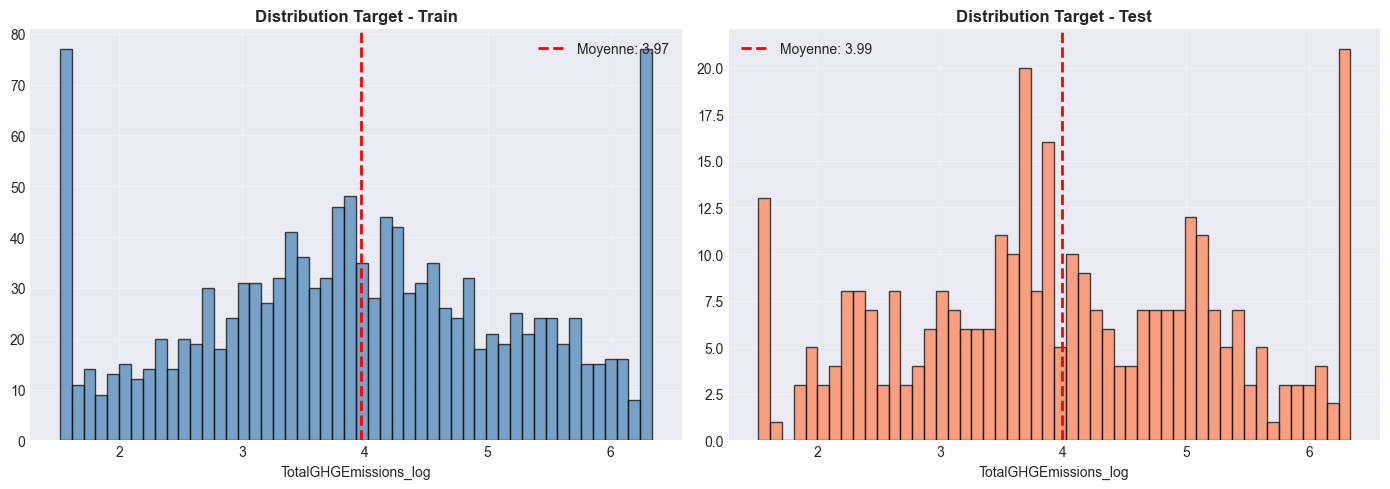

In [ ]:
# Visualisation
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].hist(y_train, bins=50, edgecolor='black', alpha=0.7, color='steelblue')
axes[0].axvline(y_train.mean(), color='red', linestyle='--', linewidth=2, label=f'Moyenne: {y_train.mean():.2f}')
axes[0].set_title('Distribution Target - Train', fontweight='bold')
axes[0].set_xlabel(TARGET)
axes[0].legend()
axes[0].grid(True, alpha=0.3)

axes[1].hist(y_test, bins=50, edgecolor='black', alpha=0.7, color='coral')
axes[1].axvline(y_test.mean(), color='red', linestyle='--', linewidth=2, label=f'Moyenne: {y_test.mean():.2f}')
axes[1].set_title('Distribution Target - Test', fontweight='bold')
axes[1].set_xlabel(TARGET)
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(FIGURES_DIR / 'target_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

# Section 3 : Définition des Variables

In [ ]:
# ============================================================================
# VARIABLES À EXCLURE
# ============================================================================

variables_a_exclure = [
    # IDs
    'OSEBuildingID', 'DataYear', 'PropertyName', 'Address',
    'TaxParcelIdentificationNumber',
    # Target
    'TotalGHGEmissions', 'TotalGHGEmissions_log',
    # Autres
    'Comments', 'ComplianceStatus', 'Outlier', 'DefaultData'
]

# ============================================================================
# MODÈLE 1 : SANS ENERGY STAR
# ============================================================================

toutes_colonnes = train_df.columns.tolist()
variables_m1 = [
    col for col in toutes_colonnes 
    if col not in variables_a_exclure and col != 'ENERGYSTARScore'
]

# ============================================================================
# MODÈLE 2 : AVEC ENERGY STAR
# ============================================================================

variables_m2 = variables_m1.copy()
if 'ENERGYSTARScore' in train_df.columns:
    variables_m2.append('ENERGYSTARScore')

print(f" MODÈLE 1 : {len(variables_m1)} features")
print(f" MODÈLE 2 : {len(variables_m2)} features")
print(f" Target : {TARGET}")

 MODÈLE 1 : 26 features
 MODÈLE 2 : 27 features
 Target : TotalGHGEmissions_log


# Section 4 : Préparation des Datasets

In [ ]:
# ============================================================================
# MODÈLE 1
# ============================================================================

print("="*80)
print("PRÉPARATION MODÈLE 1")
print("="*80)

X_train_m1 = train_df[variables_m1].copy()
X_test_m1 = test_df[variables_m1].copy()

# Gestion variables catégorielles
categorical_cols = X_train_m1.select_dtypes(include=['object']).columns.tolist()

if len(categorical_cols) > 0:
    print(f"\n⚠ {len(categorical_cols)} variables catégorielles → OneHotEncoding")
    X_train_m1 = pd.get_dummies(X_train_m1, columns=categorical_cols, drop_first=True)
    X_test_m1 = pd.get_dummies(X_test_m1, columns=categorical_cols, drop_first=True)
    X_train_m1, X_test_m1 = X_train_m1.align(X_test_m1, join='left', axis=1, fill_value=0)
    print(f"   ✓ {X_train_m1.shape[1]} features après encodage")

print(f"\n✓ X_train_m1 : {X_train_m1.shape}")
print(f"✓ X_test_m1  : {X_test_m1.shape}")

PRÉPARATION MODÈLE 1

⚠ 6 variables catégorielles → OneHotEncoding
   ✓ 465 features après encodage

✓ X_train_m1 : (1332, 465)
✓ X_test_m1  : (334, 465)


In [ ]:
# ============================================================================
# MODÈLE 2
# ============================================================================

print("="*80)
print("PRÉPARATION MODÈLE 2")
print("="*80)

X_train_m2 = train_df[variables_m2].copy()
X_test_m2 = test_df[variables_m2].copy()

# Imputation ENERGY STAR
if 'ENERGYSTARScore' in X_train_m2.columns:
    missing = X_train_m2['ENERGYSTARScore'].isnull().sum()
    if missing > 0:
        print(f"\n⚠ {missing} valeurs manquantes ENERGYSTARScore")
        median_val = X_train_m2['ENERGYSTARScore'].median()
        X_train_m2['ENERGYSTARScore'].fillna(median_val, inplace=True)
        X_test_m2['ENERGYSTARScore'].fillna(median_val, inplace=True)
        print(f"   ✓ Imputation médiane = {median_val:.2f}")

# Gestion variables catégorielles
categorical_cols_m2 = X_train_m2.select_dtypes(include=['object']).columns.tolist()

if len(categorical_cols_m2) > 0:
    print(f"\n⚠ {len(categorical_cols_m2)} variables catégorielles → OneHotEncoding")
    X_train_m2 = pd.get_dummies(X_train_m2, columns=categorical_cols_m2, drop_first=True)
    X_test_m2 = pd.get_dummies(X_test_m2, columns=categorical_cols_m2, drop_first=True)
    X_train_m2, X_test_m2 = X_train_m2.align(X_test_m2, join='left', axis=1, fill_value=0)
    print(f"   ✓ {X_train_m2.shape[1]} features après encodage")

print(f"\n✓ X_train_m2 : {X_train_m2.shape}")
print(f"✓ X_test_m2  : {X_test_m2.shape}")

PRÉPARATION MODÈLE 2

⚠ 6 variables catégorielles → OneHotEncoding
   ✓ 466 features après encodage

✓ X_train_m2 : (1332, 466)
✓ X_test_m2  : (334, 466)


# Section 5 : MODÈLE 1 - Baseline avec Pipelines

In [ ]:
# ============================================================================
# DÉFINITION PIPELINES - MODÈLE 1
# ============================================================================

print("="*80)
print("MODÈLE 1 - BASELINE AVEC PIPELINES")
print("="*80)

pipelines_m1 = {
    'Ridge': Pipeline([
        ('scaler', StandardScaler()),
        ('model', Ridge(random_state=RANDOM_STATE))
    ]),
    
    'Lasso': Pipeline([
        ('scaler', StandardScaler()),
        ('model', Lasso(random_state=RANDOM_STATE, max_iter=2000))
    ]),
    
    'Random Forest': Pipeline([
        ('scaler', StandardScaler()),
        ('model', RandomForestRegressor(
            n_estimators=100,
            random_state=RANDOM_STATE,
            n_jobs=-1
        ))
    ]),
    
    'Gradient Boosting': Pipeline([
        ('scaler', StandardScaler()),
        ('model', GradientBoostingRegressor(
            n_estimators=100,
            random_state=RANDOM_STATE
        ))
    ]),
    
    'SVR': Pipeline([
        ('scaler', StandardScaler()),
        ('model', SVR(kernel='rbf'))
    ])
}


print(f"\n✓ {len(pipelines_m1)} pipelines créés")

MODÈLE 1 - BASELINE AVEC PIPELINES

✓ 5 pipelines créés


In [ ]:
# ============================================================================
# ENTRAÎNEMENT - MODÈLE 1
# ============================================================================

results_df_m1, trained_pipelines_m1 = train_multiple_models(
    pipelines_m1,
    X_train_m1,
    y_train,
    X_test_m1,
    y_test,
    cv=5,
    verbose=True
)

print("\n RÉSULTATS BASELINE - MODÈLE 1")
display(results_df_m1[['model', 'test_r2', 'test_rmse_log', 'test_mae_log', 
                       'test_rmse_original', 'test_mape', 'overfitting_r2']].round(4))

ENTRAÎNEMENT MULTIPLE MODÈLES

Nombre de modèles : 5
Cross-validation : 5-fold

Traitement : Ridge
   → Cross-validation...
   → Entraînement...
   → Évaluation...
   ✓ Terminé en 6.92s
   R² Test : 0.6710
   RMSE Test : 0.7385

Traitement : Lasso
   → Cross-validation...
   → Entraînement...
   → Évaluation...
   ✓ Terminé en 0.37s
   R² Test : -0.0003
   RMSE Test : 1.2878

Traitement : Random Forest
   → Cross-validation...
   → Entraînement...
   → Évaluation...
   ✓ Terminé en 9.95s
   R² Test : 0.9835
   RMSE Test : 0.1652

Traitement : Gradient Boosting
   → Cross-validation...
   → Entraînement...
   → Évaluation...
   ✓ Terminé en 6.54s
   R² Test : 0.9846
   RMSE Test : 0.1599

Traitement : SVR
   → Cross-validation...
   → Entraînement...
   → Évaluation...
   ✓ Terminé en 6.20s
   R² Test : 0.6166
   RMSE Test : 0.7973

✓ ENTRAÎNEMENT TERMINÉ

 RÉSULTATS BASELINE - MODÈLE 1


,model,test_r2,test_rmse_log,test_mae_log,test_rmse_original,test_mape,overfitting_r2
3,Gradient Boosting,0.9846,0.1599,0.0875,52.0893,9.0482,0.0127
2,Random Forest,0.9835,0.1652,0.0724,50.3570,7.5391,0.0150
0,Ridge,0.6710,0.7385,0.5687,267.4425,78.8166,0.1716
4,SVR,0.6166,0.7973,0.5866,101.5368,99.6010,0.1533
1,Lasso,-0.0003,1.2878,1.0602,161.4327,184.8346,0.0003


✓ Figure sauvegardée : c:\Users\LENOVO\CO2-Emission-in-Seattle-REGO3\results\figures\baseline_m1.png


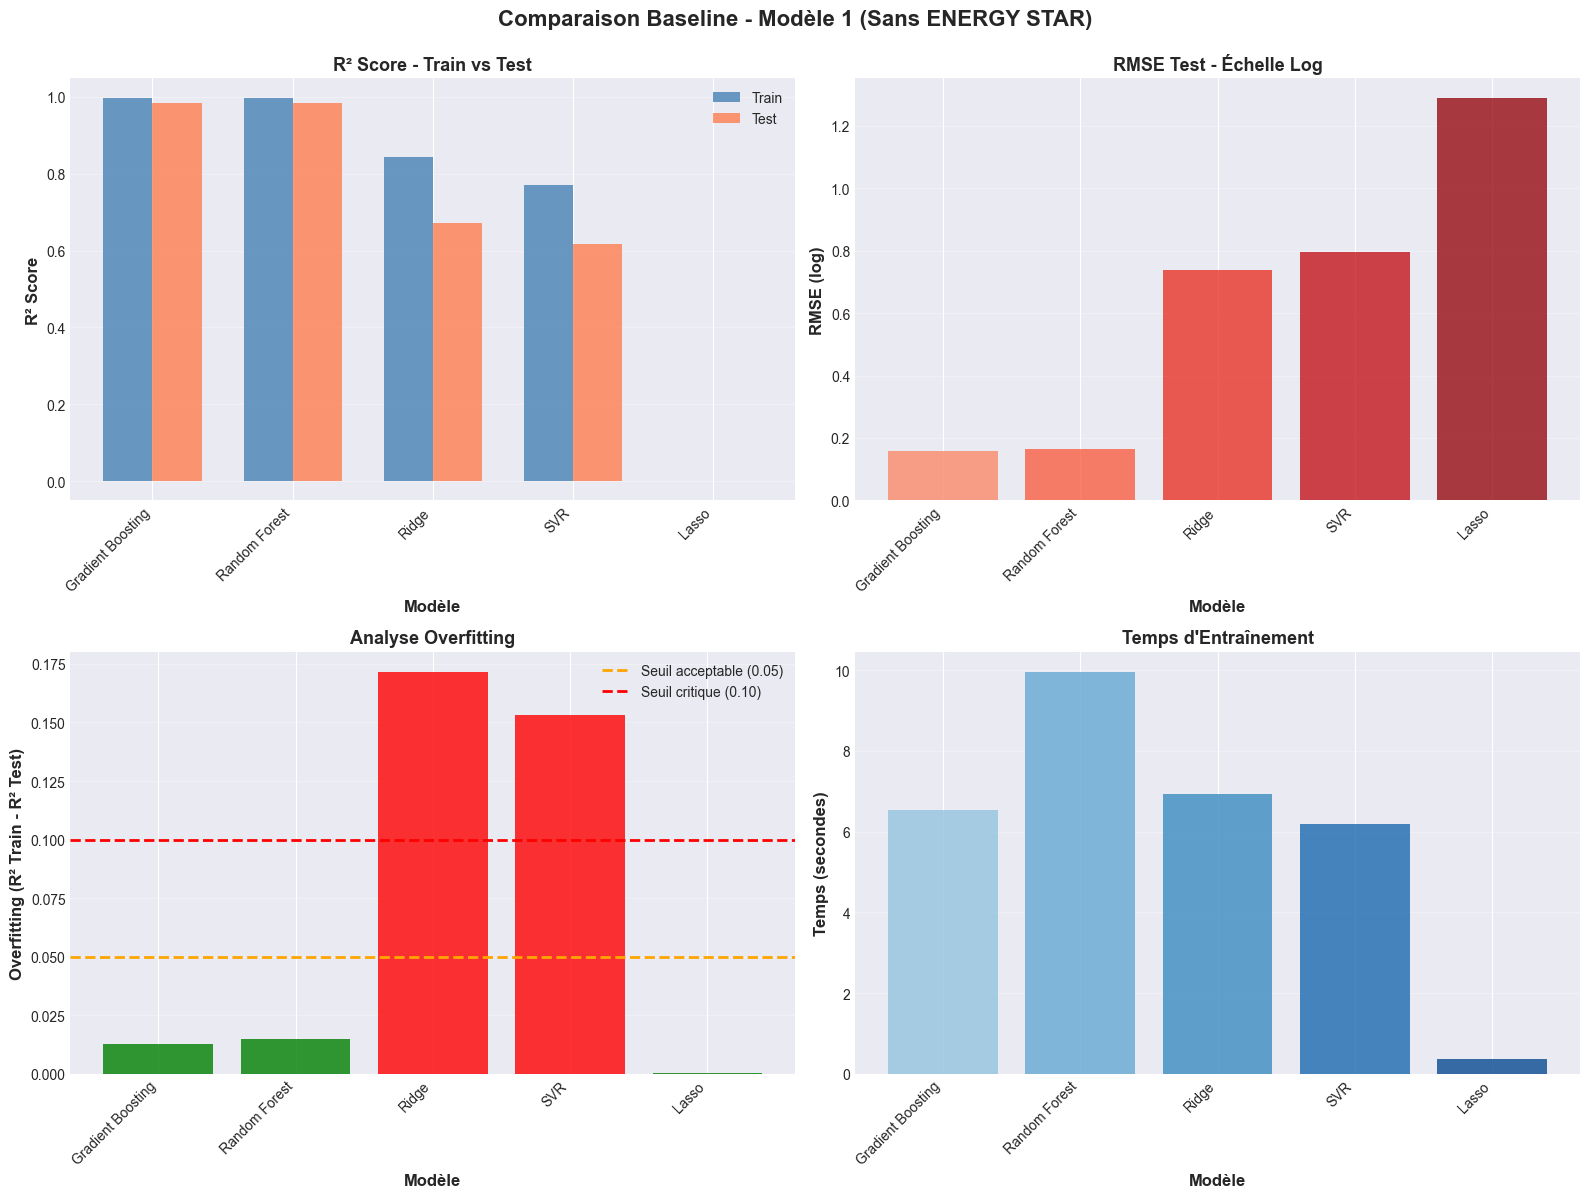

In [ ]:
# Visualisation
plot_model_comparison(
    results_df_m1,
    title="Comparaison Baseline - Modèle 1 (Sans ENERGY STAR)",
    save_path=FIGURES_DIR / 'baseline_m1.png'
)

# Section 6 : MODÈLE 1 - Analyse

In [ ]:
# ============================================================================
# MEILLEUR MODÈLE - MODÈLE 1
# ============================================================================

best_model_name_m1 = results_df_m1.iloc[0]['model']
best_pipeline_m1 = trained_pipelines_m1[best_model_name_m1]
best_metrics_m1 = results_df_m1.iloc[0].to_dict()

print("="*80)
print(f"MEILLEUR MODÈLE 1 : {best_model_name_m1}")
print("="*80)

summary_m1 = calculate_metrics_summary(best_metrics_m1)
display(summary_m1)

MEILLEUR MODÈLE 1 : Gradient Boosting


,Métrique,Valeur,Interprétation
0,R² Score (Test),0.9846,Excellent
1,RMSE (échelle originale),52.09 tonnes CO₂,Erreur moyenne quadratique
2,MAPE (%),9.05%,Excellent
3,Overfitting (R²),0.0127,Pas d'overfitting


✓ Figure sauvegardée : c:\Users\LENOVO\CO2-Emission-in-Seattle-REGO3\results\figures\feature_importance_m1.png


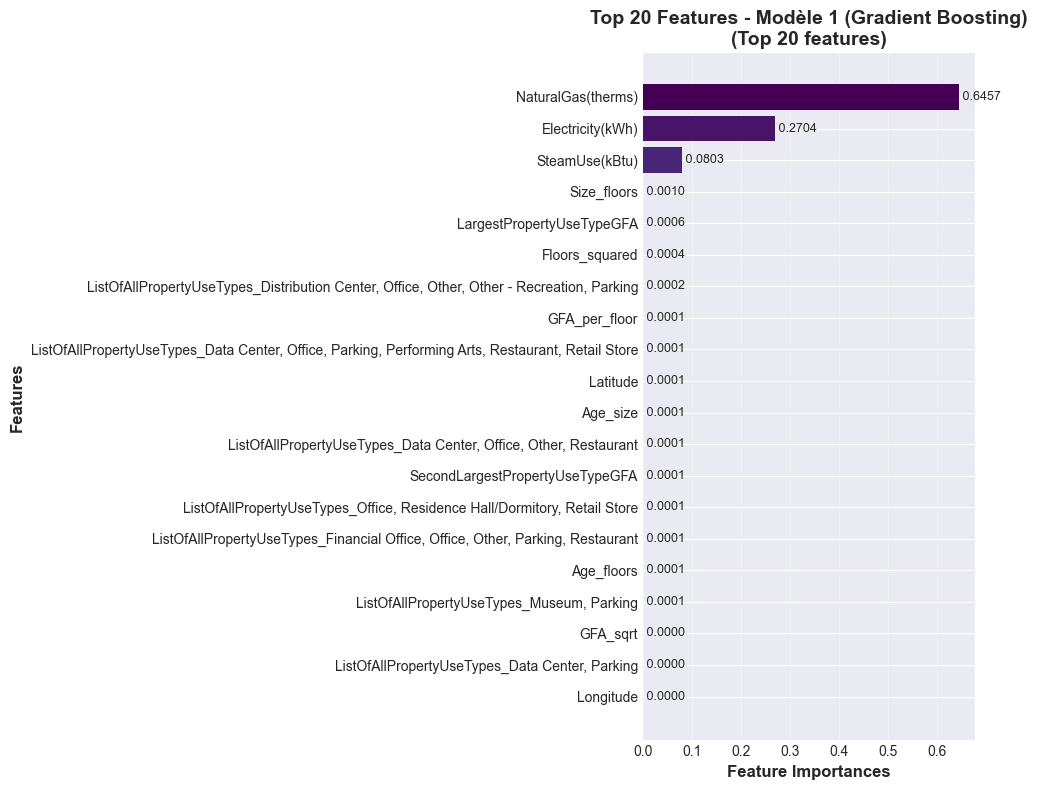


Top 10 Features :


,feature,importance
6,NaturalGas(therms),0.6457
5,Electricity(kWh),0.2704
4,SteamUse(kBtu),0.0803
11,Size_floors,0.0010
2,LargestPropertyUseTypeGFA,0.0006
15,Floors_squared,0.0004
122,"ListOfAllPropertyUseTypes_Distribution Center,...",0.0002
7,GFA_per_floor,0.0001
109,"ListOfAllPropertyUseTypes_Data Center, Office,...",0.0001
0,Latitude,0.0001


In [ ]:
# Feature Importance
if hasattr(best_pipeline_m1.named_steps['model'], 'feature_importances_') or \
   hasattr(best_pipeline_m1.named_steps['model'], 'coef_'):
    
    importance_df_m1 = plot_feature_importance(
        best_pipeline_m1.named_steps['model'],
        X_train_m1.columns,
        top_n=20,
        title=f"Top 20 Features - Modèle 1 ({best_model_name_m1})",
        save_path=FIGURES_DIR / 'feature_importance_m1.png'
    )
    
    print("\nTop 10 Features :")
    display(importance_df_m1.head(10))
else:
    print("⚠ Feature importance non disponible pour ce modèle")

✓ Figure sauvegardée : c:\Users\LENOVO\CO2-Emission-in-Seattle-REGO3\results\figures\predictions_m1.png


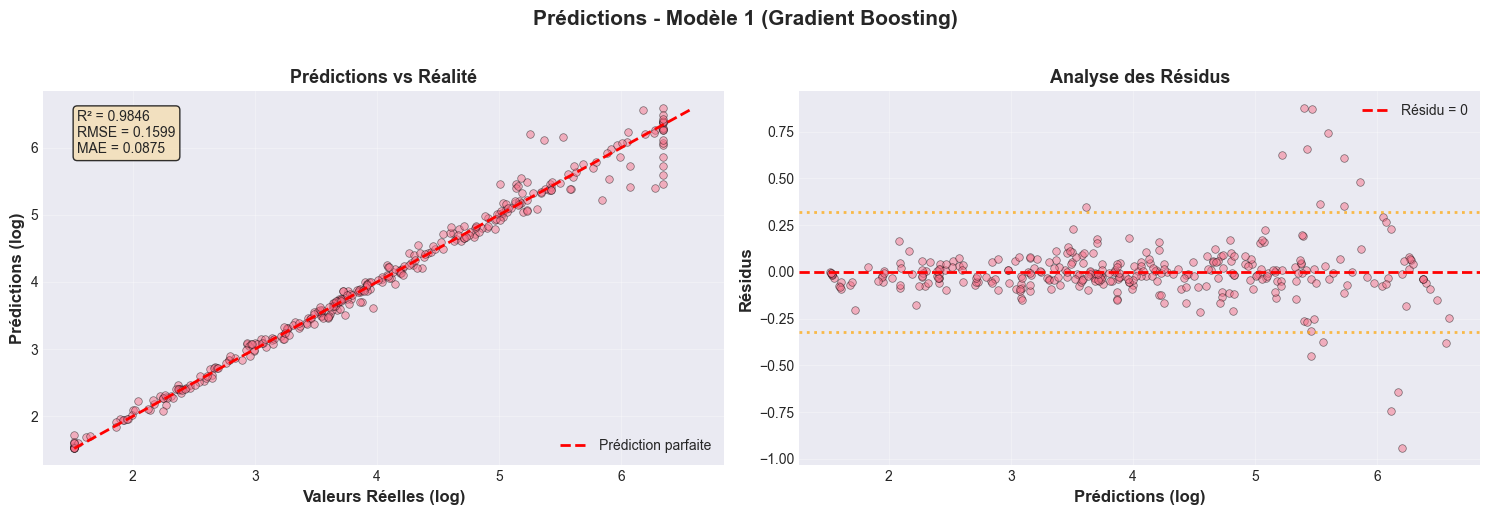

✓ Figure sauvegardée : c:\Users\LENOVO\CO2-Emission-in-Seattle-REGO3\results\figures\residuals_m1.png


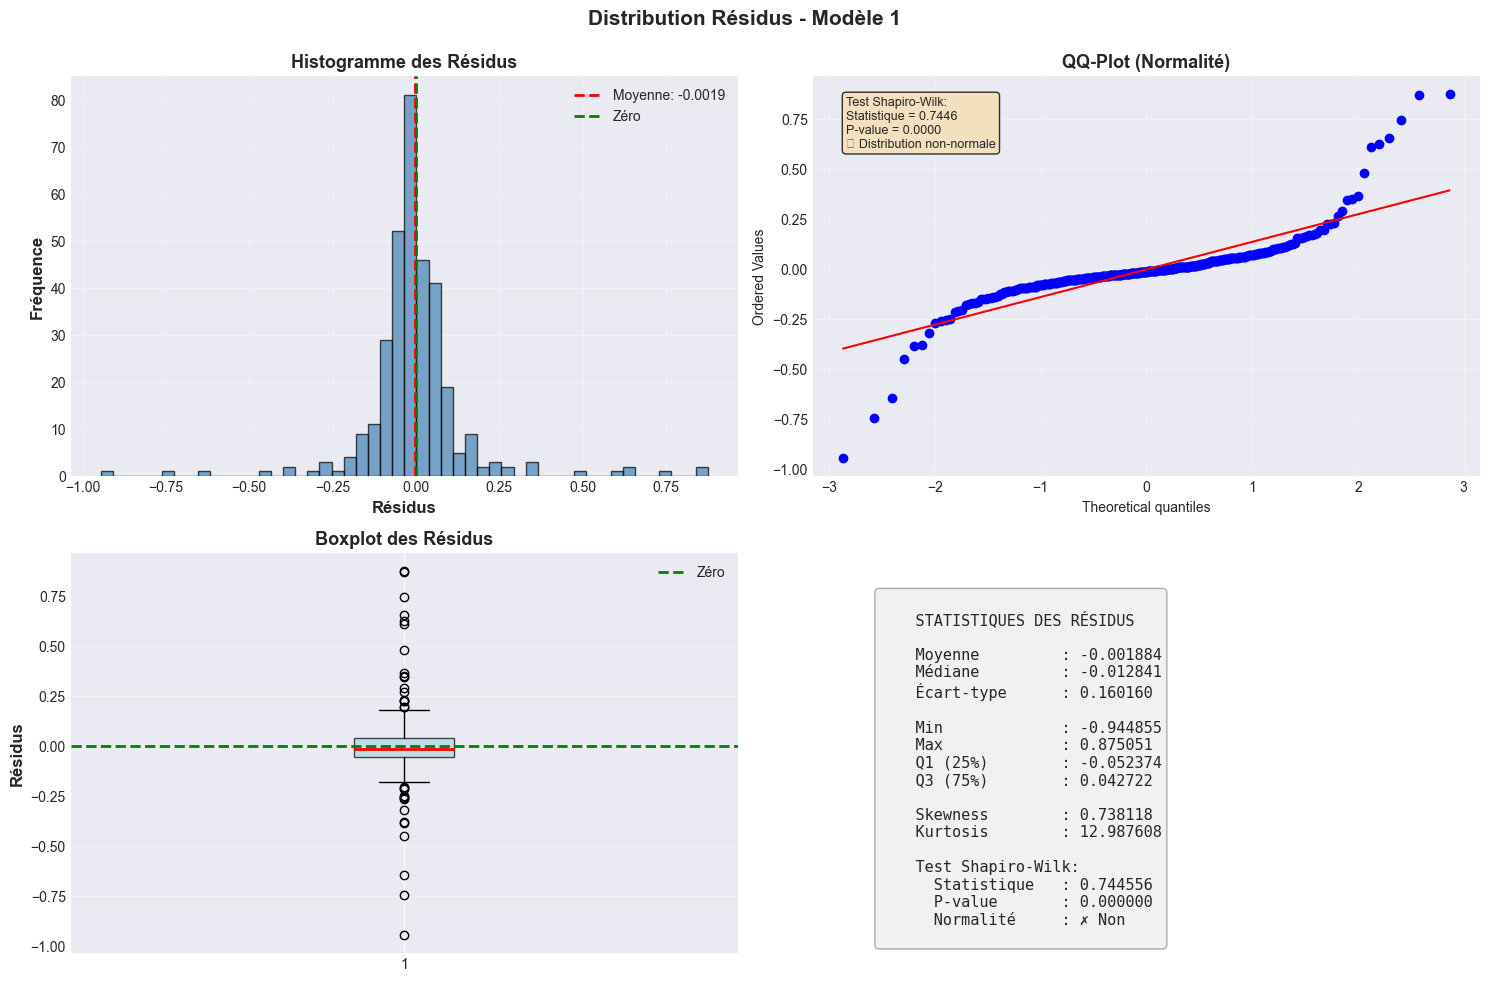

In [ ]:
# Analyse Résidus
y_pred_m1 = best_pipeline_m1.predict(X_test_m1)

plot_predictions(
    y_test, y_pred_m1,
    title=f"Prédictions - Modèle 1 ({best_model_name_m1})",
    save_path=FIGURES_DIR / 'predictions_m1.png'
)

residuals_m1 = y_test - y_pred_m1
plot_residuals_distribution(
    residuals_m1,
    title="Distribution Résidus - Modèle 1",
    save_path=FIGURES_DIR / 'residuals_m1.png'
)

# Section 7 : MODÈLE 2 - Baseline avec Pipelines

In [ ]:
# ============================================================================
# DÉFINITION PIPELINES - MODÈLE 2
# ============================================================================

print("="*80)
print("MODÈLE 2 - BASELINE AVEC PIPELINES")
print("="*80)

pipelines_m2 = {
    'Ridge': Pipeline([
        ('scaler', StandardScaler()),
        ('model', Ridge(random_state=RANDOM_STATE))
    ]),
    
    'Lasso': Pipeline([
        ('scaler', StandardScaler()),
        ('model', Lasso(random_state=RANDOM_STATE, max_iter=2000))
    ]),
    
    'Random Forest': Pipeline([
        ('scaler', StandardScaler()),
        ('model', RandomForestRegressor(
            n_estimators=100,
            random_state=RANDOM_STATE,
            n_jobs=-1
        ))
    ]),
    
    'Gradient Boosting': Pipeline([
        ('scaler', StandardScaler()),
        ('model', GradientBoostingRegressor(
            n_estimators=100,
            random_state=RANDOM_STATE
        ))
    ]),
    
    'SVR': Pipeline([
        ('scaler', StandardScaler()),
        ('model', SVR(kernel='rbf'))
    ])
}



print(f"\n✓ {len(pipelines_m2)} pipelines créés")

MODÈLE 2 - BASELINE AVEC PIPELINES

✓ 5 pipelines créés


In [ ]:
# ============================================================================
# ENTRAÎNEMENT - MODÈLE 2
# ============================================================================

results_df_m2, trained_pipelines_m2 = train_multiple_models(
    pipelines_m2,
    X_train_m2,
    y_train,
    X_test_m2,
    y_test,
    cv=5,
    verbose=True
)

print("\n RÉSULTATS BASELINE - MODÈLE 2")
display(results_df_m2[['model', 'test_r2', 'test_rmse_log', 'test_mae_log', 
                       'test_rmse_original', 'test_mape', 'overfitting_r2']].round(4))

ENTRAÎNEMENT MULTIPLE MODÈLES

Nombre de modèles : 5
Cross-validation : 5-fold

Traitement : Ridge
   → Cross-validation...
   → Entraînement...
   → Évaluation...
   ✓ Terminé en 0.52s
   R² Test : 0.6568
   RMSE Test : 0.7543

Traitement : Lasso
   → Cross-validation...
   → Entraînement...
   → Évaluation...
   ✓ Terminé en 0.51s
   R² Test : -0.0003
   RMSE Test : 1.2878

Traitement : Random Forest
   → Cross-validation...
   → Entraînement...
   → Évaluation...
   ✓ Terminé en 7.66s
   R² Test : 0.9850
   RMSE Test : 0.1580

Traitement : Gradient Boosting
   → Cross-validation...
   → Entraînement...
   → Évaluation...
   ✓ Terminé en 8.53s
   R² Test : 0.9844
   RMSE Test : 0.1608

Traitement : SVR
   → Cross-validation...
   → Entraînement...
   → Évaluation...
   ✓ Terminé en 6.00s
   R² Test : 0.6203
   RMSE Test : 0.7934

✓ ENTRAÎNEMENT TERMINÉ

📊 RÉSULTATS BASELINE - MODÈLE 2


,model,test_r2,test_rmse_log,test_mae_log,test_rmse_original,test_mape,overfitting_r2
2,Random Forest,0.9850,0.1580,0.0714,47.4485,7.3545,0.0136
3,Gradient Boosting,0.9844,0.1608,0.0874,52.0344,9.0131,0.0128
0,Ridge,0.6568,0.7543,0.5744,265.4036,80.7376,0.1924
4,SVR,0.6203,0.7934,0.5782,99.0464,99.3732,0.1602
1,Lasso,-0.0003,1.2878,1.0602,161.4327,184.8346,0.0003


✓ Figure sauvegardée : c:\Users\LENOVO\CO2-Emission-in-Seattle-REGO3\results\figures\baseline_m2.png


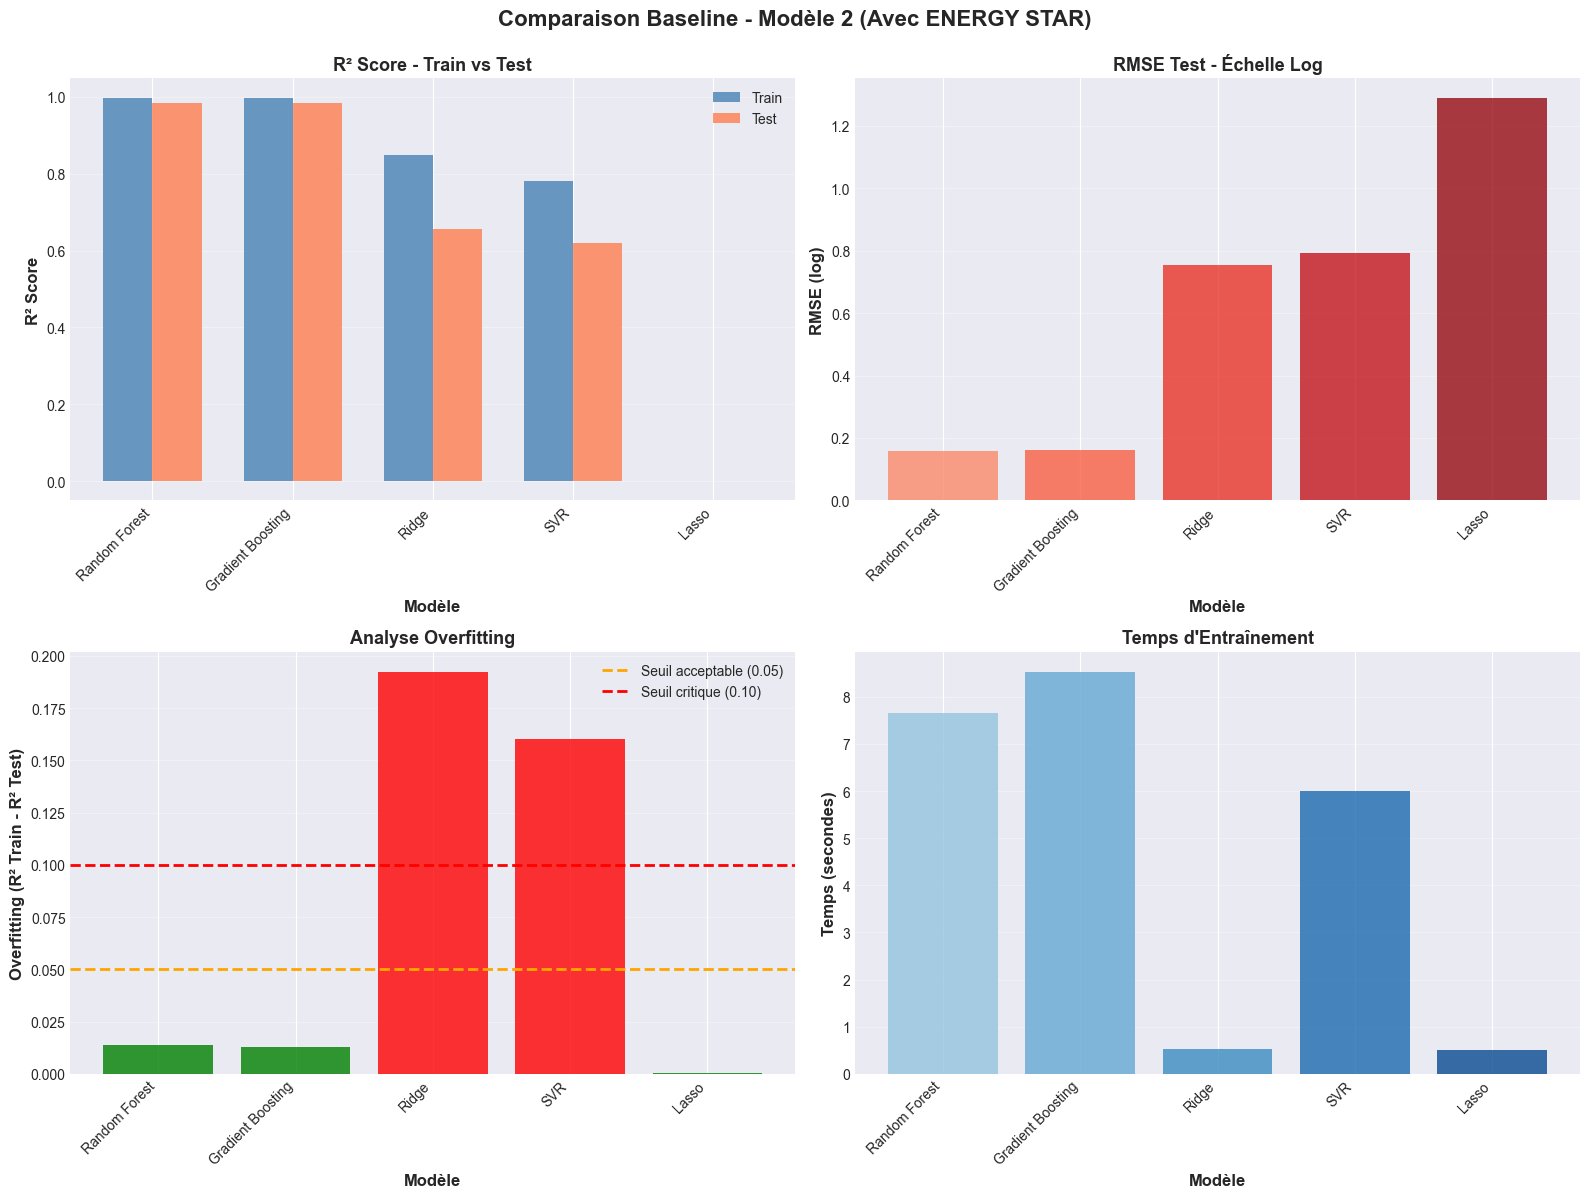

In [ ]:
# Visualisation
plot_model_comparison(
    results_df_m2,
    title="Comparaison Baseline - Modèle 2 (Avec ENERGY STAR)",
    save_path=FIGURES_DIR / 'baseline_m2.png'
)

# Section 8 : MODÈLE 2 - Analyse

In [ ]:
# ============================================================================
# MEILLEUR MODÈLE - MODÈLE 2
# ============================================================================

best_model_name_m2 = results_df_m2.iloc[0]['model']
best_pipeline_m2 = trained_pipelines_m2[best_model_name_m2]
best_metrics_m2 = results_df_m2.iloc[0].to_dict()

print("="*80)
print(f"MEILLEUR MODÈLE 2 : {best_model_name_m2}")
print("="*80)

summary_m2 = calculate_metrics_summary(best_metrics_m2)
display(summary_m2)

MEILLEUR MODÈLE 2 : Random Forest


,Métrique,Valeur,Interprétation
0,R² Score (Test),0.9850,Excellent
1,RMSE (échelle originale),47.45 tonnes CO₂,Erreur moyenne quadratique
2,MAPE (%),7.35%,Excellent
3,Overfitting (R²),0.0136,Pas d'overfitting


✓ Figure sauvegardée : c:\Users\LENOVO\CO2-Emission-in-Seattle-REGO3\results\figures\feature_importance_m2.png


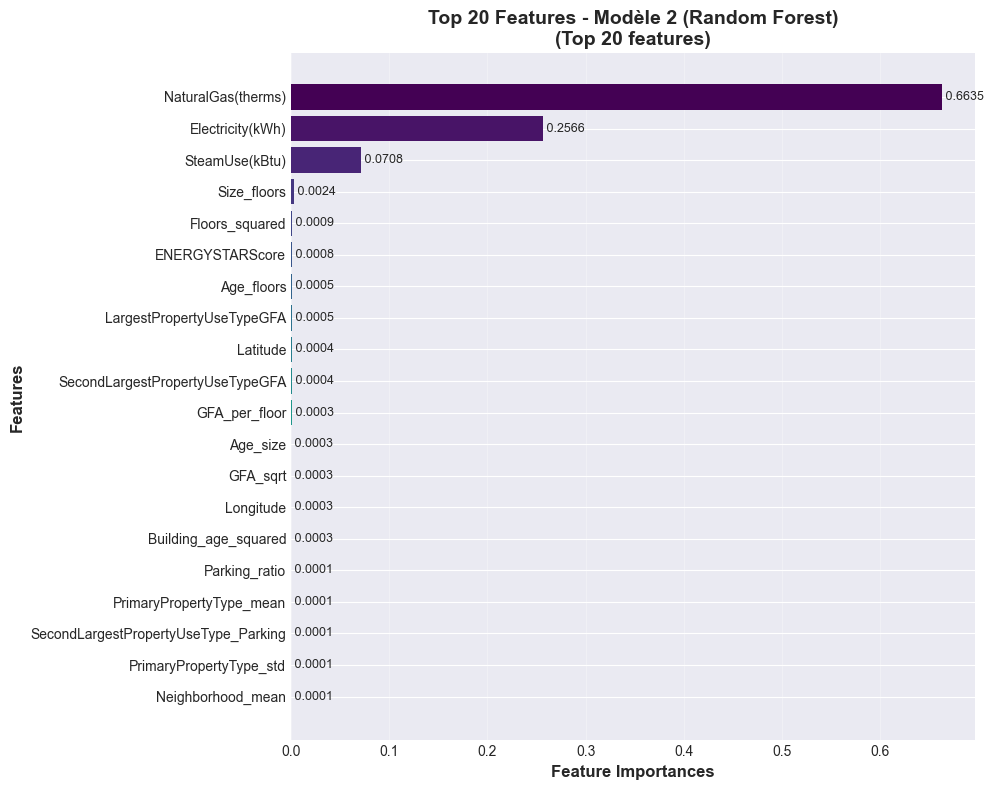


Top 10 Features :


,feature,importance
6,NaturalGas(therms),0.6635
5,Electricity(kWh),0.2566
4,SteamUse(kBtu),0.0708
11,Size_floors,0.0024
15,Floors_squared,0.0009
20,ENERGYSTARScore,0.0008
13,Age_floors,0.0005
2,LargestPropertyUseTypeGFA,0.0005
0,Latitude,0.0004
3,SecondLargestPropertyUseTypeGFA,0.0004



⭐ ENERGYSTARScore : Rang 21 | Importance 0.0008


In [ ]:
# Feature Importance + Position ENERGY STAR
if hasattr(best_pipeline_m2.named_steps['model'], 'feature_importances_') or \
   hasattr(best_pipeline_m2.named_steps['model'], 'coef_'):
    
    importance_df_m2 = plot_feature_importance(
        best_pipeline_m2.named_steps['model'],
        X_train_m2.columns,
        top_n=20,
        title=f"Top 20 Features - Modèle 2 ({best_model_name_m2})",
        save_path=FIGURES_DIR / 'feature_importance_m2.png'
    )
    
    print("\nTop 10 Features :")
    display(importance_df_m2.head(10))
    
    # Position ENERGY STAR
    if 'ENERGYSTARScore' in importance_df_m2['feature'].values:
        energy_rank = importance_df_m2[importance_df_m2['feature'] == 'ENERGYSTARScore'].index[0] + 1
        energy_importance = importance_df_m2[importance_df_m2['feature'] == 'ENERGYSTARScore']['importance'].values[0]
        print(f"\n ENERGYSTARScore : Rang {energy_rank} | Importance {energy_importance:.4f}")
else:
    print("⚠ Feature importance non disponible")

✓ Figure sauvegardée : c:\Users\LENOVO\CO2-Emission-in-Seattle-REGO3\results\figures\predictions_m2.png


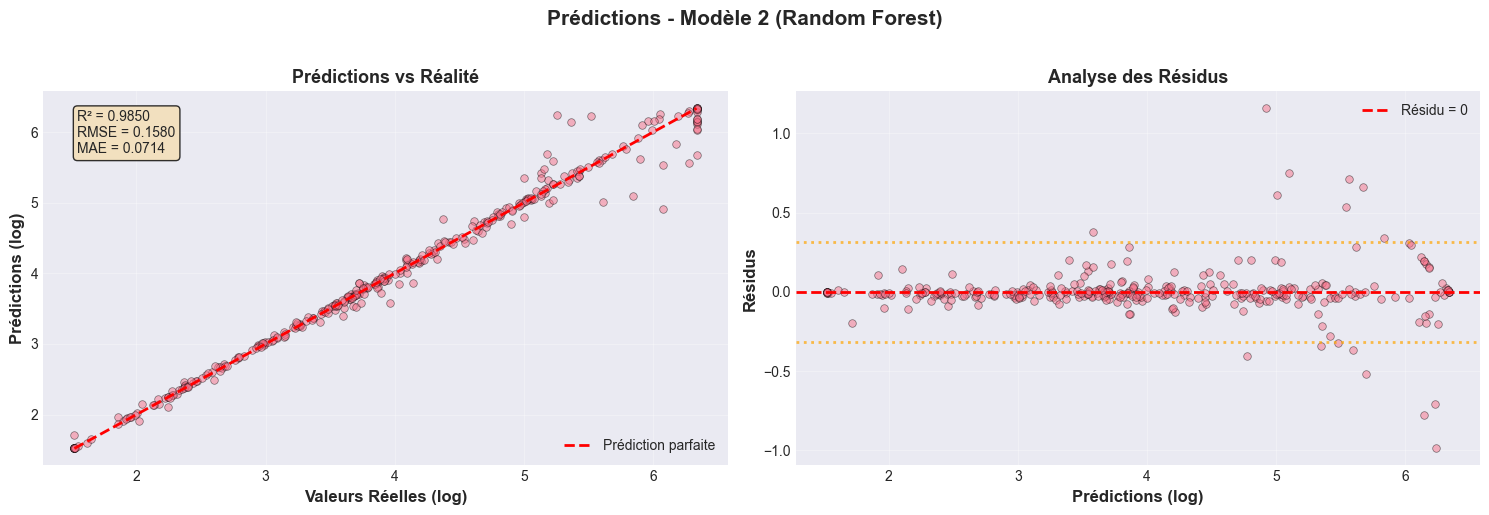

✓ Figure sauvegardée : c:\Users\LENOVO\CO2-Emission-in-Seattle-REGO3\results\figures\residuals_m2.png


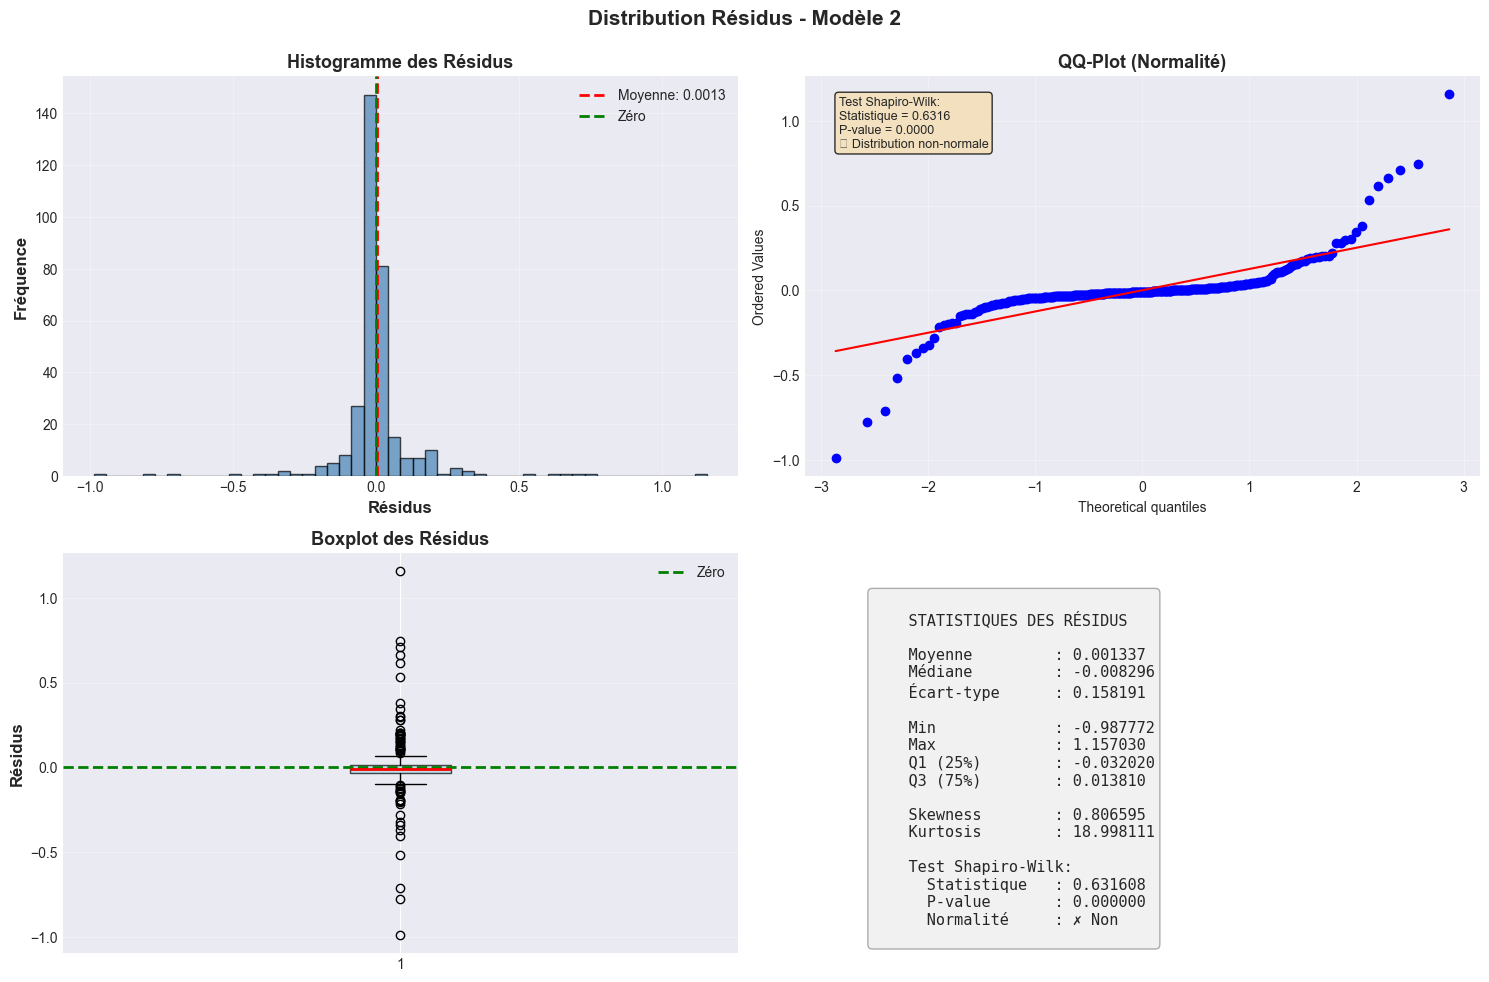

In [ ]:
# Analyse Résidus
y_pred_m2 = best_pipeline_m2.predict(X_test_m2)

plot_predictions(
    y_test, y_pred_m2,
    title=f"Prédictions - Modèle 2 ({best_model_name_m2})",
    save_path=FIGURES_DIR / 'predictions_m2.png'
)

residuals_m2 = y_test - y_pred_m2
plot_residuals_distribution(
    residuals_m2,
    title="Distribution Résidus - Modèle 2",
    save_path=FIGURES_DIR / 'residuals_m2.png'
)

# Section 9 : Comparaison MODÈLE 1 vs MODÈLE 2

In [ ]:
# ============================================================================
# COMPARAISON DÉTAILLÉE
# ============================================================================

print("="*80)
print("COMPARAISON MODÈLE 1 vs MODÈLE 2")
print("="*80)

comparison = compare_model_performance(
    best_metrics_m1,
    best_metrics_m2,
    "Modèle 1 (Sans ENERGY STAR)",
    "Modèle 2 (Avec ENERGY STAR)"
)

display(comparison)

COMPARAISON MODÈLE 1 vs MODÈLE 2


,Métrique,Modèle 1 (Sans ENERGY STAR),Modèle 2 (Avec ENERGY STAR),Différence,Amélioration (%),Meilleur
0,R² Test,0.9846,0.9850,+0.0004,+0.04%,Modèle 2 (Avec ENERGY STAR)
1,RMSE Test (log),0.1599,0.1580,-0.0020,+1.23%,Modèle 2 (Avec ENERGY STAR)
2,MAE Test (log),0.0875,0.0714,-0.0161,+18.45%,Modèle 2 (Avec ENERGY STAR)
3,RMSE Test (original),52.0893,47.4485,-4.6409,+8.91%,Modèle 2 (Avec ENERGY STAR)
4,MAPE Test (%),9.0482,7.3545,-1.6937,+18.72%,Modèle 2 (Avec ENERGY STAR)
5,Overfitting R²,0.0127,0.0136,+0.0009,-6.95%,Modèle 1 (Sans ENERGY STAR)


✓ Figure sauvegardée : c:\Users\LENOVO\CO2-Emission-in-Seattle-REGO3\results\figures\comparison_m1_m2.png


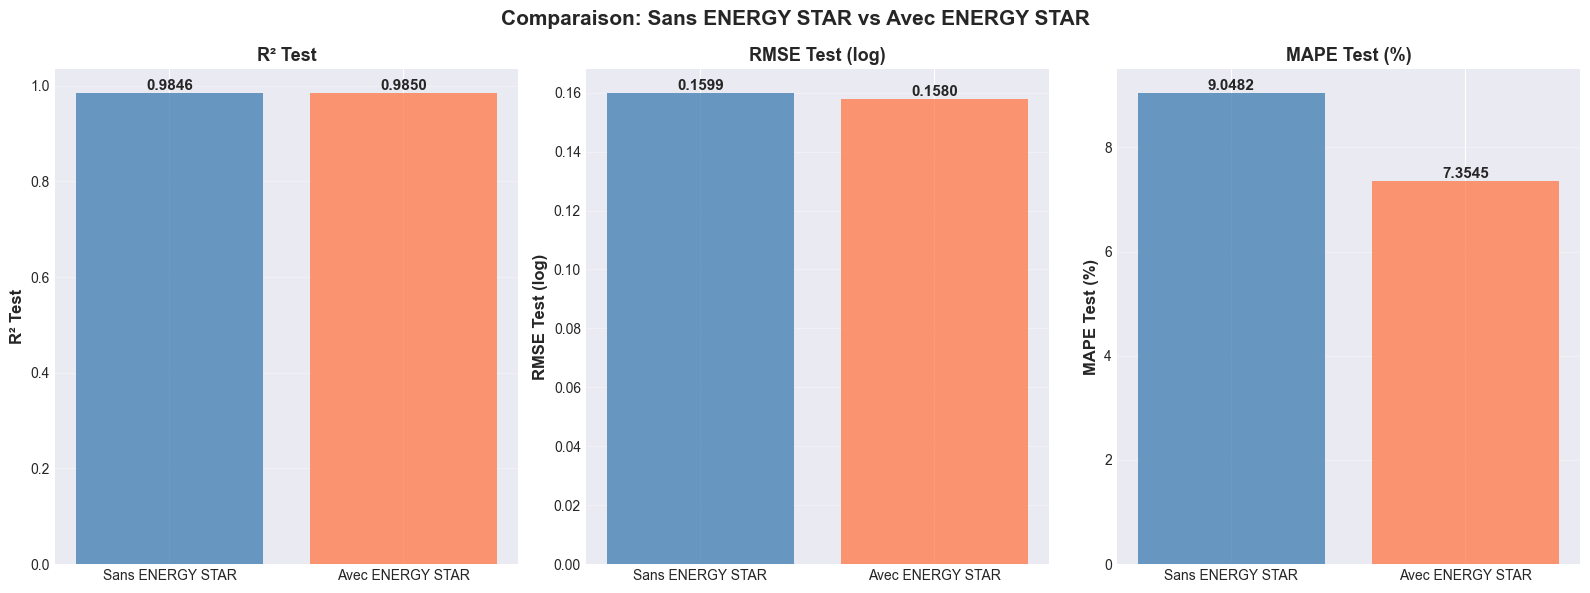

In [ ]:
# Visualisation comparative
plot_comparison_two_models(
    results_df_m1,
    results_df_m2,
    "Sans ENERGY STAR",
    "Avec ENERGY STAR",
    save_path=FIGURES_DIR / 'comparison_m1_m2.png'
)

# Section 10 : Analyse Apport ENERGY STAR

In [ ]:
# ============================================================================
# ANALYSE APPORT ENERGY STAR
# ============================================================================

print("="*80)
print("ANALYSE APPORT ENERGY STAR SCORE")
print("="*80)

gain_r2 = best_metrics_m2['test_r2'] - best_metrics_m1['test_r2']
gain_rmse = best_metrics_m1['test_rmse_log'] - best_metrics_m2['test_rmse_log']
gain_mape = best_metrics_m1['test_mape'] - best_metrics_m2['test_mape']

print(f"\n GAINS DE PERFORMANCE")
print(f"\nR² Score :")
print(f"  Modèle 1 : {best_metrics_m1['test_r2']:.4f}")
print(f"  Modèle 2 : {best_metrics_m2['test_r2']:.4f}")
print(f"  Gain     : {gain_r2:+.4f} ({gain_r2/best_metrics_m1['test_r2']*100:+.1f}%)")

print(f"\nRMSE (log) :")
print(f"  Modèle 1 : {best_metrics_m1['test_rmse_log']:.4f}")
print(f"  Modèle 2 : {best_metrics_m2['test_rmse_log']:.4f}")
print(f"  Gain     : {gain_rmse:+.4f} ({gain_rmse/best_metrics_m1['test_rmse_log']*100:+.1f}%)")

print(f"\nMAPE :")
print(f"  Modèle 1 : {best_metrics_m1['test_mape']:.2f}%")
print(f"  Modèle 2 : {best_metrics_m2['test_mape']:.2f}%")
print(f"  Gain     : {gain_mape:+.2f}%")

ANALYSE APPORT ENERGY STAR SCORE

📊 GAINS DE PERFORMANCE

R² Score :
  Modèle 1 : 0.9846
  Modèle 2 : 0.9850
  Gain     : +0.0004 (+0.0%)

RMSE (log) :
  Modèle 1 : 0.1599
  Modèle 2 : 0.1580
  Gain     : +0.0020 (+1.2%)

MAPE :
  Modèle 1 : 9.05%
  Modèle 2 : 7.35%
  Gain     : +1.69%



📈 Corrélation ENERGYSTARScore - Target : -0.1072


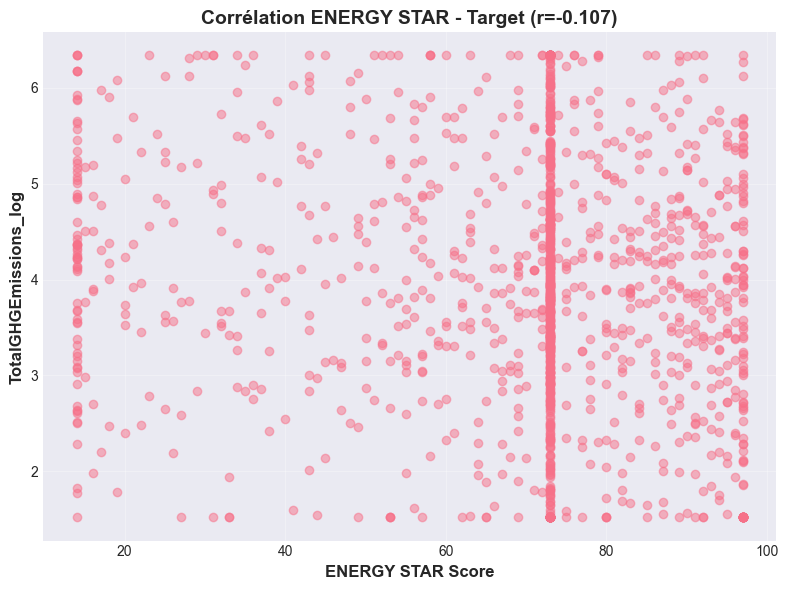

In [ ]:
# Corrélation ENERGY STAR avec Target
if 'ENERGYSTARScore' in train_df.columns:
    corr = train_df[['ENERGYSTARScore', TARGET]].corr().iloc[0, 1]
    print(f"\n📈 Corrélation ENERGYSTARScore - Target : {corr:.4f}")
    
    plt.figure(figsize=(8, 6))
    plt.scatter(train_df['ENERGYSTARScore'], train_df[TARGET], alpha=0.5)
    plt.xlabel('ENERGY STAR Score', fontsize=12, fontweight='bold')
    plt.ylabel(TARGET, fontsize=12, fontweight='bold')
    plt.title(f'Corrélation ENERGY STAR - Target (r={corr:.3f})', fontsize=14, fontweight='bold')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig(FIGURES_DIR / 'energy_star_correlation.png', dpi=300, bbox_inches='tight')
    plt.show()

# Section 11 : Recommandations Stratégiques

In [ ]:
print("="*80)
print("RECOMMANDATIONS STRATÉGIQUES")
print("="*80)

print("\n🎯 QUAND UTILISER QUEL MODÈLE ?")

print("\n MODÈLE 1 (Sans ENERGY STAR) :")
print("  • Prédiction sur nouveaux bâtiments (permis de construction)")
print("  • ENERGY STAR Score non disponible")
print("  • Approche prédictive pure")
print(f"  • Performance : R² = {best_metrics_m1['test_r2']:.3f}")

print("\n MODÈLE 2 (Avec ENERGY STAR) :")
print("  • Bâtiments existants avec certification ENERGY STAR")
print("  • Maximisation de la performance prédictive")
print("  • Évaluation de l'efficacité énergétique")
print(f"  • Performance : R² = {best_metrics_m2['test_r2']:.3f}")

print(f"\n GAIN ENERGY STAR : {gain_r2/best_metrics_m1['test_r2']*100:+.1f}% de variance expliquée")

if gain_r2 > 0.1:
    print("\n⭐ CONCLUSION : ENERGY STAR apporte un gain SIGNIFICATIF")
elif gain_r2 > 0.05:
    print("\n⭐ CONCLUSION : ENERGY STAR apporte un gain MODÉRÉ")
else:
    print("\n⭐ CONCLUSION : ENERGY STAR apporte un gain FAIBLE")

RECOMMANDATIONS STRATÉGIQUES

🎯 QUAND UTILISER QUEL MODÈLE ?

 MODÈLE 1 (Sans ENERGY STAR) :
  • Prédiction sur nouveaux bâtiments (permis de construction)
  • ENERGY STAR Score non disponible
  • Approche prédictive pure
  • Performance : R² = 0.985

 MODÈLE 2 (Avec ENERGY STAR) :
  • Bâtiments existants avec certification ENERGY STAR
  • Maximisation de la performance prédictive
  • Évaluation de l'efficacité énergétique
  • Performance : R² = 0.985

 GAIN ENERGY STAR : +0.0% de variance expliquée

⭐ CONCLUSION : ENERGY STAR apporte un gain FAIBLE


# Section 12 : Prédictions Finales

In [ ]:
# ============================================================================
# PRÉDICTIONS ÉCHELLE LOG
# ============================================================================

print("="*80)
print("PRÉDICTIONS FINALES")
print("="*80)

y_pred_m1_log = best_pipeline_m1.predict(X_test_m1)
y_pred_m2_log = best_pipeline_m2.predict(X_test_m2)

# ============================================================================
# RETRANSFORMATION ÉCHELLE ORIGINALE
# ============================================================================

y_test_original = np.expm1(y_test)
y_pred_m1_original = np.expm1(y_pred_m1_log)
y_pred_m2_original = np.expm1(y_pred_m2_log)

print(f"\n✓ Prédictions Modèle 1 : {len(y_pred_m1_original)} observations")
print(f"✓ Prédictions Modèle 2 : {len(y_pred_m2_original)} observations")

PRÉDICTIONS FINALES

✓ Prédictions Modèle 1 : 334 observations
✓ Prédictions Modèle 2 : 334 observations


In [ ]:
# ============================================================================
# MÉTRIQUES ÉCHELLE ORIGINALE
# ============================================================================

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

print("\n📊 MÉTRIQUES FINALES (Échelle Originale - Tonnes CO₂)")

print("\nModèle 1 :")
print(f"  RMSE : {np.sqrt(mean_squared_error(y_test_original, y_pred_m1_original)):.2f} tonnes")
print(f"  MAE  : {mean_absolute_error(y_test_original, y_pred_m1_original):.2f} tonnes")
print(f"  R²   : {r2_score(y_test_original, y_pred_m1_original):.4f}")

print("\nModèle 2 :")
print(f"  RMSE : {np.sqrt(mean_squared_error(y_test_original, y_pred_m2_original)):.2f} tonnes")
print(f"  MAE  : {mean_absolute_error(y_test_original, y_pred_m2_original):.2f} tonnes")
print(f"  R²   : {r2_score(y_test_original, y_pred_m2_original):.4f}")


📊 MÉTRIQUES FINALES (Échelle Originale - Tonnes CO₂)

Modèle 1 :
  RMSE : 52.09 tonnes
  MAE  : 17.47 tonnes
  R²   : 0.8775

Modèle 2 :
  RMSE : 47.45 tonnes
  MAE  : 15.03 tonnes
  R²   : 0.8984


In [ ]:
# ============================================================================
# EXPORT RÉSULTATS
# ============================================================================

results_final = pd.DataFrame({
    'y_true': y_test_original,
    'y_pred_m1': y_pred_m1_original,
    'y_pred_m2': y_pred_m2_original,
    'error_m1': y_test_original - y_pred_m1_original,
    'error_m2': y_test_original - y_pred_m2_original,
    'abs_error_m1': np.abs(y_test_original - y_pred_m1_original),
    'abs_error_m2': np.abs(y_test_original - y_pred_m2_original)
})

results_final.to_csv(RESULTS_DIR / 'predictions_finales.csv', index=False)
print(f"\n✓ Prédictions sauvegardées : {RESULTS_DIR / 'predictions_finales.csv'}")


✓ Prédictions sauvegardées : c:\Users\LENOVO\CO2-Emission-in-Seattle-REGO3\results\predictions_finales.csv


# Section 13 : Sauvegarde des Modèles

In [ ]:
# ============================================================================
# SAUVEGARDE PIPELINES
# ============================================================================

print("="*80)
print("SAUVEGARDE DES MODÈLES")
print("="*80)

# Modèle 1
save_model(
    best_pipeline_m1,
    MODELS_DIR / 'pipeline_modele1_best.pkl',
    metadata=best_metrics_m1,
    verbose=True
)

# Modèle 2
save_model(
    best_pipeline_m2,
    MODELS_DIR / 'pipeline_modele2_best.pkl',
    metadata=best_metrics_m2,
    verbose=True
)

SAUVEGARDE DES MODÈLES
✓ Modèle sauvegardé : c:\Users\LENOVO\CO2-Emission-in-Seattle-REGO3\models\pipeline_modele1_best.pkl
✓ Métadonnées sauvegardées : c:\Users\LENOVO\CO2-Emission-in-Seattle-REGO3\models\pipeline_modele1_best.json
✓ Modèle sauvegardé : c:\Users\LENOVO\CO2-Emission-in-Seattle-REGO3\models\pipeline_modele2_best.pkl
✓ Métadonnées sauvegardées : c:\Users\LENOVO\CO2-Emission-in-Seattle-REGO3\models\pipeline_modele2_best.json


In [ ]:
# ============================================================================
# SAUVEGARDE MÉTRIQUES COMPARATIVES
# ============================================================================

import json

metrics_comparison = {
    'modele_1': {
        'nom': best_model_name_m1,
        'r2_test': float(best_metrics_m1['test_r2']),
        'rmse_test_log': float(best_metrics_m1['test_rmse_log']),
        'rmse_test_original': float(best_metrics_m1['test_rmse_original']),
        'mape_test': float(best_metrics_m1['test_mape'])
    },
    'modele_2': {
        'nom': best_model_name_m2,
        'r2_test': float(best_metrics_m2['test_r2']),
        'rmse_test_log': float(best_metrics_m2['test_rmse_log']),
        'rmse_test_original': float(best_metrics_m2['test_rmse_original']),
        'mape_test': float(best_metrics_m2['test_mape'])
    },
    'gains': {
        'r2': float(gain_r2),
        'rmse': float(gain_rmse),
        'mape': float(gain_mape)
    }
}

with open(RESULTS_DIR / 'metrics_comparison.json', 'w') as f:
    json.dump(metrics_comparison, f, indent=4)

print(f"✓ Métriques comparatives sauvegardées : {RESULTS_DIR / 'metrics_comparison.json'}")

✓ Métriques comparatives sauvegardées : c:\Users\LENOVO\CO2-Emission-in-Seattle-REGO3\results\metrics_comparison.json


# Section 14 : Conclusions

In [ ]:
print("="*80)
print("CONCLUSIONS FINALES")
print("="*80)

print(f"\n RÉSUMÉ DES PERFORMANCES")
print(f"\nModèle 1 ({best_model_name_m1}) - Sans ENERGY STAR :")
print(f"  • R² Test : {best_metrics_m1['test_r2']:.4f}")
print(f"  • RMSE : {best_metrics_m1['test_rmse_original']:.2f} tonnes CO₂")
print(f"  • MAPE : {best_metrics_m1['test_mape']:.2f}%")

print(f"\nModèle 2 ({best_model_name_m2}) - Avec ENERGY STAR :")
print(f"  • R² Test : {best_metrics_m2['test_r2']:.4f}")
print(f"  • RMSE : {best_metrics_m2['test_rmse_original']:.2f} tonnes CO₂")
print(f"  • MAPE : {best_metrics_m2['test_mape']:.2f}%")

print(f"\n RÉPONSE À LA QUESTION PRINCIPALE :")
print(f"\n   L'ajout d'ENERGY STAR Score améliore le R² de {gain_r2:+.4f}")
print(f"   soit une amélioration relative de {gain_r2/best_metrics_m1['test_r2']*100:+.1f}%")

print("\n LIVRABLES GÉNÉRÉS :")
print(f"  • {len(list(FIGURES_DIR.glob('*.png')))} visualisations")
print(f"  • 2 pipelines sauvegardés")
print(f"  • Prédictions finales exportées")
print(f"  • Métriques comparatives JSON")

print("\n" + "="*80)
print("✓ MODÉLISATION TERMINÉE AVEC SUCCÈS")
print("="*80)

CONCLUSIONS FINALES

 RÉSUMÉ DES PERFORMANCES

Modèle 1 (Gradient Boosting) - Sans ENERGY STAR :
  • R² Test : 0.9846
  • RMSE : 52.09 tonnes CO₂
  • MAPE : 9.05%

Modèle 2 (Random Forest) - Avec ENERGY STAR :
  • R² Test : 0.9850
  • RMSE : 47.45 tonnes CO₂
  • MAPE : 7.35%

 RÉPONSE À LA QUESTION PRINCIPALE :

   L'ajout d'ENERGY STAR Score améliore le R² de +0.0004
   soit une amélioration relative de +0.0%

 LIVRABLES GÉNÉRÉS :
  • 11 visualisations
  • 2 pipelines sauvegardés
  • Prédictions finales exportées
  • Métriques comparatives JSON

✓ MODÉLISATION TERMINÉE AVEC SUCCÈS
